In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.mixture import GaussianMixture
import scipy.linalg as linalg
import pandas as pd

# ------------------------------
# 1. Load and Preprocess CIFAR10
# ------------------------------
(x_train, _), (x_test, _) = cifar10.load_data()
# Normalize images to [0,1]
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
print("x_train shape:", x_train.shape)

# ------------------------------
# 2. Define the Convolutional Autoencoder
# ------------------------------
latent_dim = 128  # dimension of latent space

# Encoder
input_img = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.MaxPooling2D((2, 2), padding="same")(x)  # 16x16
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)  # 8x8
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)  # 4x4
x = layers.Flatten()(x)
latent = layers.Dense(latent_dim, name="latent")(x)
encoder = keras.Model(input_img, latent, name="encoder")
encoder.summary()

# Decoder
latent_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(4 * 4 * 128, activation="relu")(latent_input)
x = layers.Reshape((4, 4, 128))(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)  # 8x8
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)   # 16x16
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)   # 32x32
decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_input, decoded, name="decoder")
decoder.summary()

# Autoencoder = Encoder + Decoder
autoencoder = keras.Model(input_img, decoder(encoder(input_img)), name="autoencoder")
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

# ------------------------------
# 3. Train the Autoencoder
# ------------------------------
# For demonstration, you might want to use fewer epochs
epochs = 2
batch_size = 128
autoencoder.fit(
    x_train,
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, x_test)
)

# ------------------------------
# 4. Encode Training Images & Save Latent Representations
# ------------------------------
latent_reps = encoder.predict(x_train)
# Save latent representations to a CSV file
latent_df = pd.DataFrame(latent_reps)
latent_df.to_csv("latent_representations.csv", index=False)
print("Latent representations saved to latent_representations.csv")

# ------------------------------
# 5. Fit a Generative Model on the Latent Space
# ------------------------------
# Using a Gaussian Mixture Model (GMM) as the generative model
n_components = 10  # you can adjust this hyperparameter
gmm = GaussianMixture(n_components=n_components, covariance_type="full", random_state=42)
gmm.fit(latent_reps)
print("GMM fitted on latent representations.")

# ------------------------------
# 6. Sample New Latent Codes and Decode to Generate New Images
# ------------------------------
num_samples = 9  # number of new images to generate
sampled_latents, _ = gmm.sample(num_samples)
generated_images = decoder.predict(sampled_latents)
print("Generated images shape:", generated_images.shape)

# ------------------------------
# 7. Define Functions for FID Calculation
# ------------------------------
def get_inception_activations(images, model, batch_size=32):
    """
    Resize images to (299,299,3), preprocess them for InceptionV3,
    and get activations from the specified model.
    """
    # Resize images to the size InceptionV3 expects
    images_resized = tf.image.resize(images, (299, 299))
    images_resized = preprocess_input(images_resized)
    # Use model to get activations
    activations = model.predict(images_resized, batch_size=batch_size)
    return activations

def calculate_fid(act1, act2):
    """
    Compute the Fréchet Inception Distance between two sets of activations.
    """
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    # Numerical stability: remove imaginary component if any
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# ------------------------------
# 8. Evaluate Generated Images using FID
# ------------------------------
# Load InceptionV3 model for feature extraction (exclude top classification layer)
inception_model = InceptionV3(include_top=False, pooling="avg", input_shape=(299, 299, 3))

# For a fair evaluation, use a sample of real images.
# Here we sample 1000 images from x_train.
n_eval = 10
indices = np.random.choice(x_train.shape[0], n_eval, replace=False)
real_sample = x_train[indices]

# Get activations for real and generated images.
# Note: if num_samples (generated images) is small, FID might be less stable.
real_activations = get_inception_activations(real_sample, inception_model, batch_size=32)
gen_activations = get_inception_activations(generated_images, inception_model, batch_size=32)

fid_value = calculate_fid(real_activations, gen_activations)
print("FID score between real and generated images: {:.2f}".format(fid_value))


x_train shape: (50000, 32, 32, 3)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 128)            │       262,272 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,520 (1.36 MB)

 Trainable params: 355,520 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 504,899 (1.93 MB)

 Trainable params: 504,899 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 128)            │       355,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 32, 3)      │       504,899 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 860,419 (3.28 MB)

 Trainable params: 860,419 (3.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - loss: 0.0356 - val_loss: 0.0138
Epoch 2/2
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - loss: 0.0127 - val_loss: 0.0109
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Latent representations saved to latent_representations.csv
GMM fitted on latent representations.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Generated images shape: (9, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
FID score between real and generated images: 0.57


In [6]:
# For a fair evaluation, use a sample of real images.
# Here we sample 1000 images from x_train.
n_eval = 9
indices = np.random.choice(x_train.shape[0], n_eval, replace=False)
real_sample = x_train[indices]

# Get activations for real and generated images.
# Note: if num_samples (generated images) is small, FID might be less stable.
real_activations = get_inception_activations(real_sample, inception_model, batch_size=32)
gen_activations = get_inception_activations(generated_images, inception_model, batch_size=32)

fid_value = calculate_fid(real_activations, gen_activations)
print("FID score between real and generated images: {:.2f}".format(fid_value))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
FID score between real and generated images: 0.62


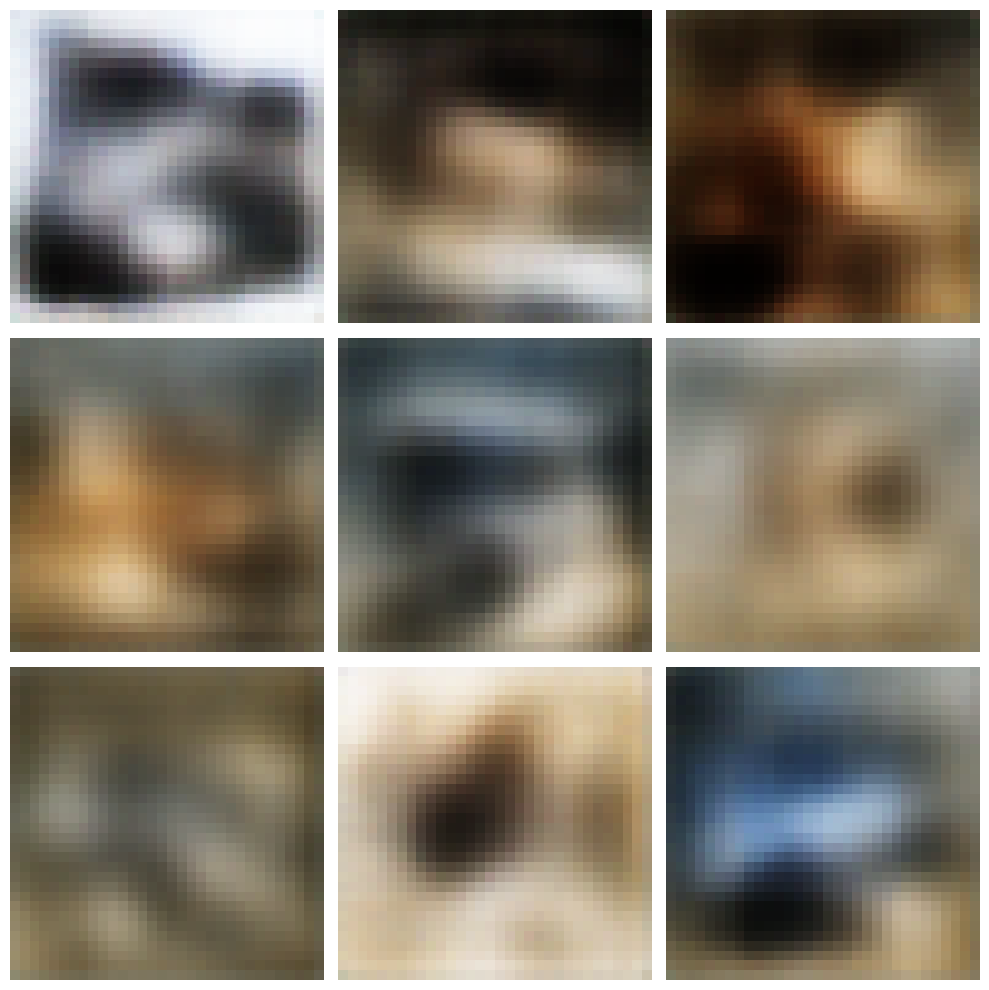

In [7]:
import matplotlib.pyplot as plt

# Assume generated_images is a numpy array of shape (num_samples, 32, 32, 3)
num_images = generated_images.shape[0]
grid_size = int(np.sqrt(num_images))  # e.g., for 100 images, grid_size = 10

plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(generated_images[i])
    plt.axis("off")
plt.tight_layout()
plt.show()